In [1]:
# import libraries
import itertools
import asyncio
import numpy as np, matplotlib.pyplot as plt
import numpy
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
from rtlsdr import RtlSdr
import pyModeS as pms
import gc
import pdb
import time
from sklearn.cluster import KMeans
from scipy.signal import convolve
%matplotlib inline

/home/james/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sdr = RtlSdr()
fs = 2048000;
sdr.set_sample_rate(fs)    # sampling rate
sdr.set_center_freq(434.03e6)   # 1090MhZ center frequency
sdr.set_gain(0) 
N_Samples = 2048000 # approx 1 sec

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


In [3]:
THRESHOLD = 0.015
PREAMBLE_SEQUENCE = [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]

In [4]:
def convert_to_binary(sequence, threshold):
    return [int(val > threshold) for val in sequence]

In [5]:
def downsample(sample, orig_freq, new_freq):
    assert 0 < new_freq < orig_freq, "New freq must be less than original frequency and greater than zero"
    assert orig_freq / new_freq == orig_freq // new_freq, "Original frequency must be a multiple of the new frequency"
    return sample[::orig_freq // new_freq]

In [6]:
def detect_data_from_preamble(buffer, i):
    detected_indices = []
    new_i = i
    for j in range(i, len(buffer) - 32):
        # Compute the score
        score = (buffer[j:j+16] == PREAMBLE_SEQUENCE)
        # If score == 1, return i + 16
        if score == True:
            detected_indices.append(j)
            new_i = j+32
        
    return detected_indices, new_i

In [7]:
def decode(pulse_pattern):
    result = []
    assert len(pulse_pattern) == 16
    for i in range(0, 16, 2):
        if pulse_pattern[i] == 1 and pulse_pattern[i+1] == 0:
            result.append(1)
        elif pulse_pattern[i+1] == 1 and pulse_pattern[i] == 0:
            result.append(0)
        else:
            result.append(0)
    res = 0
    for i in range(8):
        res += 2**(i) * result[i]
    return res

def convert_to_char(ascii_index):
    return chr(ascii_index)
    

In [8]:
def read_and_return_data(buffer):
    y = abs(sdr.read_samples(N_Samples))   # get samples
    y = downsample(y, fs, 200)
    data = convert_to_binary(y)
    buffer.extend(data)
    return buffer

In [9]:
def plot_data(data):
    width, height = figaspect(0.2)
    fig = figure(figsize=(width ,height ))
    p = plot( (data))
    title('magnitude of received signal')
    xlabel('samples')

In [10]:
def extract_chars_from_data(buffer, i):
    res = []
    detected, new_i = detect_data_from_preamble(buffer, i)
    for item in detected:
        char = convert_to_char(decode(buffer[item+16:item+32]))
        res.append(char)
    return res, new_i

In [11]:
def correlation(template, buffer):
    t_len = len(template)
    b_len = len(buffer)
    correlations = []
    for i in range(b_len - t_len + 1):
        correlation = 0
        for j in range(t_len):
            if template[j] == buffer[i+j]:
                correlation += 1
        correlations.append(correlation / t_len)
    return correlations

In [12]:
# Steps
# 1) Apply a smoothing filter on the data to remove noise and jitter
# 2) Use k-means clustering to find high and low values in the data
# 3) do clock recovery
#   a) Take the fourier transform
#   b) Look in the 90 to 110 Hzer  range to find the pulse frequency
# 4) Use that to sample our signal at the the right sampling rate and recover the data

In [13]:
def smoothing_filter(samples):
    sigma = 3
    kernel_size = int(3 * sigma) + 1
    kernel = np.exp(-(np.arange(kernel_size) - kernel_size // 2)**2 / (2 * sigma**2))
    kernel /= np.sum(kernel)
    smoothed_samples = convolve(data, kernel, mode='same')
    return smoothed_samples

In [14]:
kmeans = KMeans(n_clusters=2)
def find_amplitude_cutoff(samples):
    kmeans.fit(samples.reshape(-1, 1))
    centers = kmeans.cluster_centers_
    val1 = centers[0][0]
    val2 = centers[1][0]
    return min([val1, val2]), max([val1, val2])

In [15]:
def autocorrelate_signal(samples):
    autocorrelation = numpy.correlate(samples, samples, mode='full')
    peak_index = argmax(autocorrelation)
    peak_frequency = peak_index / len(samples) * 100 * 64
    return peak_frequency

In [26]:
def find_pulse_frequency_and_phase(samples):
    change_indices = []
    for i in range(len(samples) - 1):
        if samples[i] != samples[i+1]:
            change_indices.append(i)
    
    # Compute period
    differences = diff(change_indices)
    filtered_values = filter(lambda x: x >= 60 and x <= 70, differences)
    period = int(mean(list(filtered_values)))
    
    midpoints = []
    for i in range(len(change_indices) - 1):
        if 60 <= change_indices[i+1] - change_indices[i] <= 70:
            midpoints.append(((change_indices[i+1] - change_indices[i]) / 2) % period)
    
    return int(mean(midpoints)), period
        

In [17]:
def extract_data(sample, phase, period):
    return sample[phase::period]

low is 0.005742278394137737 and high is 0.013610284931335492
0
20
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 

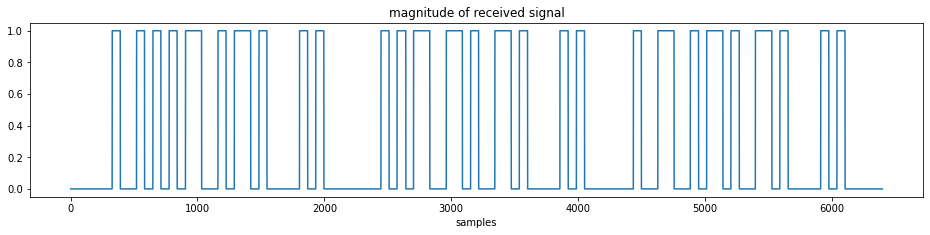

In [18]:
data = abs(sdr.read_samples(N_Samples))
data = downsample(data, fs, 100 * 64)
# Create the Gaussian kernel.
data = smoothing_filter(data)
low, high = find_amplitude_cutoff(data)
print(f"low is {low} and high is {high}")
data = convert_to_binary(data, (low + high) / 2)
plot_data(data)
phase, period = find_pulse_frequency_and_phase(data)
print(phase)
print(period)
data = extract_data(data, phase, period)
print(data)

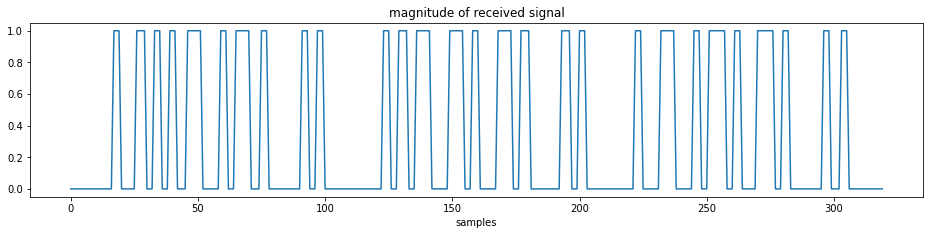

In [19]:
plot_data(data[:2000])

In [20]:
find_amplitude_cutoff(data)

AttributeError: 'list' object has no attribute 'reshape'

NameError: name 't' is not defined

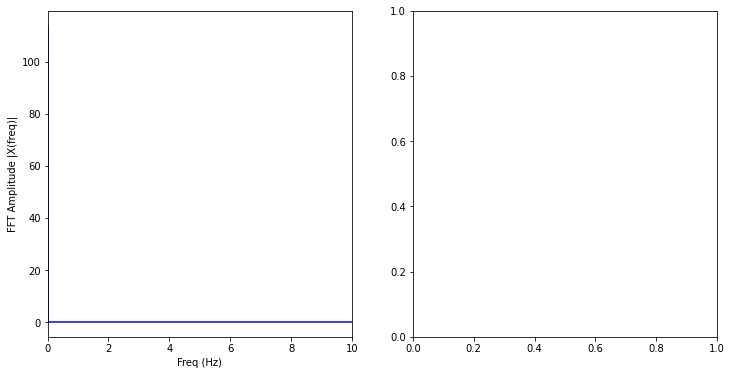

In [21]:
data_fft = fft(data)
N = len(data)
n = np.arange(N)
T = N/fs
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(data_fft), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(data_fft), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

(array([206.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 114.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

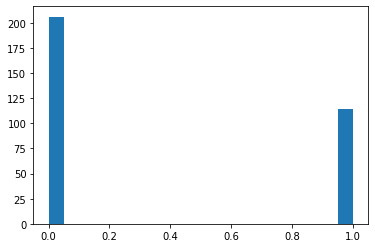

In [22]:
hist(data, bins=20)

In [23]:
buffer = []
i = 0
start = time.time()
while True:
    # pdb.set_trace()
#     buffer = read_and_return_data(buffer)
    #     current = time.time()
    y = abs(sdr.read_samples(N_Samples))   # get samples
    y = downsample(y, fs, 100)
    current = time.time()
    print(f"{current - start} elapsed time")
    print(f"Read {len(y)}")
    start = current
    # buffer.append(y)
    
#     chars, new_i = extract_chars_from_data(buffer, i)
#     print("".join(chars), end="")
#     i = new_i

1.0705766677856445 elapsed time
Read 100
1.064272403717041 elapsed time
Read 100
1.0568535327911377 elapsed time
Read 100
1.0603609085083008 elapsed time
Read 100
1.0607225894927979 elapsed time
Read 100
1.0617270469665527 elapsed time
Read 100
1.0597028732299805 elapsed time
Read 100
1.0452234745025635 elapsed time
Read 100
1.06632399559021 elapsed time
Read 100


KeyboardInterrupt: 

In [ ]:
hist(list(buffer[0]) + list(buffer[1]), bins=30)

low is 0.00577923546595158 and high is 0.016677945742989357
32
64
[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
['d']
77


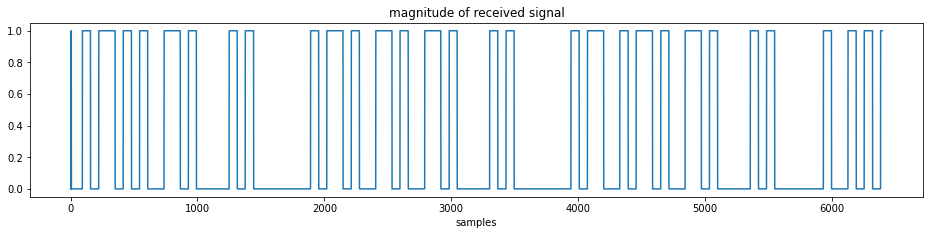

In [43]:
data = abs(sdr.read_samples(N_Samples))
data = downsample(data, fs, 100 * 64)
# Create the Gaussian kernel.
data = smoothing_filter(data)
low, high = find_amplitude_cutoff(data)
print(f"low is {low} and high is {high}")
data = convert_to_binary(data, (low + high) / 2)
plot_data(data)
phase, period = find_pulse_frequency_and_phase(data)
print(phase)
print(period)
data = extract_data(data, phase, period)
print(data)
chars, i = extract_chars_from_data(data, 0)
print(chars)
print(i)

In [236]:


async def streaming(buffer_1s, downsampled_buffer, start_time):
    i = 0
    pdb.set_trace()
    async for samples in sdr.stream():
        buffer_1s.extend(abs(samples))
        if len(buffer_1s) > fs:
            raw_downsamples = downsample(buffer_1s[:fs], fs, 100 * 64)
            buffer_1s = buffer_1s[fs:]
            
            # Window and process data
            data = smoothing_filter(raw_downsamples)
            low, high = find_amplitude_cutoff(data)
            cutoff_threshold = (low + high) / 2
            data = convert_to_binary(data, cutoff_threshold)
            phase, period = find_pulse_frequency_and_phase(data)
            data = extract_data(data, phase, period)
            downsampled_buffer.extend(data)
            # print(raw_downsamples)
            
            chars, new_i = extract_chars_from_data(downsampled_buffer, i)
            print("".join(chars), end="")
            i = new_i
        current = time.time()
            
#         print(buffer_1s[:100])
#         print(raw_downsamples)
#         print(downsamples)
#         print(f"{current - start_time} elapsed time")
#         print(f"Read {len(samples)}, total downsampled buffer length {len(downsampled_buffer)}")
#         print(f"Average downsampled samples / sec {len(downsampled_buffer) / (current - start_time)}")

In [ ]:
buffer_1s = []
downsampled_buffer = []
start_time = time.time()
await streaming(buffer_1s, downsampled_buffer, start_time)

> /tmp/ipykernel_24273/3549589541.py(4)streaming()
      2     i = 0
      3     pdb.set_trace()
----> 4     async for samples in sdr.stream():
      5         buffer_1s.extend(abs(samples))
      6         if len(buffer_1s) > fs:

ipdb> b 7
Breakpoint 4 at /tmp/ipykernel_24273/3549589541.py:7
ipdb> c
> /tmp/ipykernel_24273/3549589541.py(7)streaming()
      5         buffer_1s.extend(abs(samples))
      6         if len(buffer_1s) > fs:
4---> 7             raw_downsamples = downsample(buffer_1s[:fs], fs, 100 * 64)
      8             buffer_1s = buffer_1s[fs:]
      9 

ipdb> n
> /tmp/ipykernel_24273/3549589541.py(8)streaming()
      6         if len(buffer_1s) > fs:
4     7             raw_downsamples = downsample(buffer_1s[:fs], fs, 100 * 64)
----> 8             buffer_1s = buffer_1s[fs:]
      9 
     10             # Window and process data

ipdb> n
> /tmp/ipykernel_24273/3549589541.py(11)streaming()
      9 
     10             # Window and process data
---> 11             data = 

ipdb> n
> /tmp/ipykernel_24273/3549589541.py(17)streaming()
     15             phase, period = find_pulse_frequency_and_phase(data)
     16             data = extract_data(data, phase, period)
---> 17             downsampled_buffer.extend(data)
     18             # print(raw_downsamples)
     19 

ipdb> n
> /tmp/ipykernel_24273/3549589541.py(20)streaming()
     18             # print(raw_downsamples)
     19 
---> 20             chars, new_i = extract_chars_from_data(downsampled_buffer, i)
     21             print("".join(chars), end="")
     22             i = new_i

ipdb> data
[0, 0]


In [230]:
data = [0.12173393, 0.16776821, 0.19539148, 0.2218425 , 0.26988436,
       0.32012248, 0.3475327 , 0.39367666, 0.41517166, 0.42970374,
       0.46093666, 0.49071768, 0.49545417, 0.51816387, 0.51679242,
       0.49141849, 0.48424722, 0.45239271, 0.44388381, 0.43474911,
       0.42550071, 0.41675756, 0.40353723, 0.36785586, 0.33381923,
       0.31983434, 0.2835024 , 0.26759307, 0.27278793, 0.23896063,
       0.23316995, 0.25586932, 0.2408481 , 0.24891553, 0.27982995,
       0.29098235, 0.32466086, 0.34343305, 0.36481455, 0.38754839,
       0.41041483, 0.42668698, 0.45990281, 0.49175153, 0.49847093,
       0.5229207 , 0.5229207 , 0.49847093, 0.49175153, 0.45990281,
       0.45102126, 0.4412297 , 0.449835  , 0.41675756, 0.40353723,
       0.36785586, 0.33381923, 0.31983434, 0.2835024 , 0.29192736,
       0.27926852, 0.24609808, 0.24068006, 0.23903933, 0.24141996,
       0.24790635, 0.27707667, 0.2864948 , 0.31864227, 0.33627093,
       0.35704096, 0.35544052, 0.39677213, 0.41353093, 0.44790516,
       0.48149395, 0.49040931, 0.51736428, 0.50133389, 0.50296428,
       0.49785514, 0.46741724, 0.47837231, 0.44598653, 0.45596327,
       0.42381   , 0.41104154, 0.37536596, 0.34095668, 0.32631492,
       0.30783669, 0.26759307, 0.24845365, 0.20814576, 0.17088335,
       0.15525773, 0.11911418, 0.1054816 , 0.09091906, 0.0762773 ]

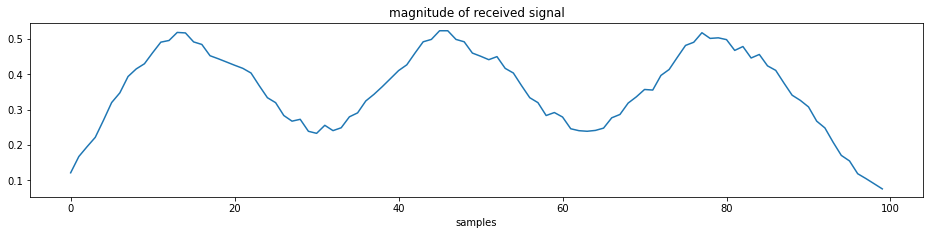

In [231]:
plot_data(data)

In [25]:
data = [0.022866478019001095, 0.005545935538718, 0.02772967769359011, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.02772967769359008, 0.005545935538718, 0.022866478019001095, 0.005545935538718, 0.022866478019001095, 0.005545935538718, 0.029865776885740814, 0.005545935538718, 0.029865776885740814, 0.005545935538718, 0.03373460889036312, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.022866478019001095, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.03551131426720554, 0.005545935538718, 0.03373460889036321, 0.005545935538718, 0.03551131426720543, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.02772967769359016, 0.005545935538718, 0.03551131426720554, 0.005545935538718, 0.033734608890363275, 0.005545935538718, 0.029865776885740814, 0.005545935538718, 0.02772967769359016, 0.005545935538718, 0.03551131426720554, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.0372032665902162, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.03373460889036321, 0.005545935538718, 0.029865776885740814, 0.005545935538718, 0.029865776885740814, 0.005545935538718, 0.03551131426720554, 0.005545935538718, 0.03551131426720543, 0.005545935538718, 0.03373460889036312, 0.005545935538718, 0.033734608890363185, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.02772967769359011, 0.005545935538718, 0.033734608890363275, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.033734608890363275, 0.005545935538718, 0.03373460889036321, 0.005545935538718, 0.033734608890363185, 0.005545935538718, 0.03551131426720543, 0.005545935538718, 0.022866478019001095, 0.005545935538718, 0.02772967769359011, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.03373460889036321, 0.005545935538718, 0.03551131426720554, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.02772967769359008, 0.005545935538718, 0.02772967769359, 0.005545935538718]

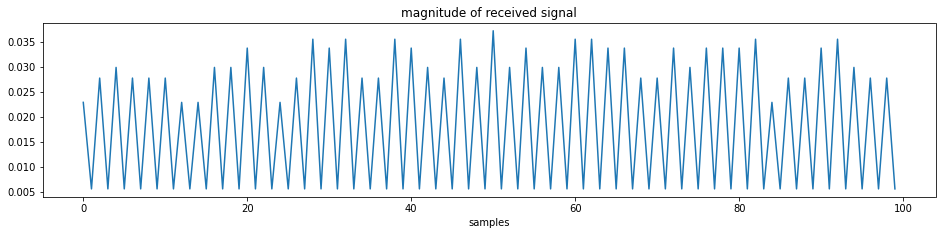

In [26]:
plot_data(data)

In [17]:
buffer

[array([0.00554594, 0.01240109, 0.00554594, ..., 0.00554594, 0.00554594,
        0.00554594]),
 array([0.00554594, 0.00554594, 0.00554594, ..., 0.02286648, 0.02286648,
        0.02772968]),
 array([0.02772968, 0.02772968, 0.02986578, ..., 0.00554594, 0.00554594,
        0.01240109]),
 array([0.00554594, 0.00554594, 0.00554594, ..., 0.00554594, 0.00554594,
        0.00554594]),
 array([0.00554594, 0.00554594, 0.00554594, ..., 0.02286648, 0.02986578,
        0.01999615]),
 array([0.01999615, 0.02286648, 0.02286648, ..., 0.00554594, 0.00554594,
        0.00554594]),
 array([0.00554594, 0.00554594, 0.00554594, ..., 0.02986578, 0.02986578,
        0.02772968]),
 array([0.02772968, 0.01999615, 0.02986578, ..., 0.02986578, 0.02986578,
        0.02772968]),
 array([0.03551131, 0.02986578, 0.03373461, ..., 0.00554594, 0.00554594,
        0.00554594]),
 array([0.00554594, 0.00554594, 0.00554594, ..., 0.03373461, 0.03373461,
        0.02986578]),
 array([0.02986578, 0.02772968, 0.03551131, ..., 0

In [1]:
buffer = [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]

In [2]:
template = [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]

Text(0, 0.5, 'Value')

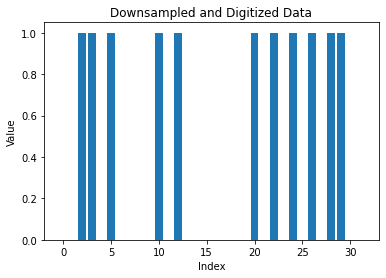

In [18]:
bar(range(32), buffer[:32])
title("Downsampled and Digitized Data")
xlabel("Time (us)")
ylabel("Value")

Text(0, 0.5, 'Value')

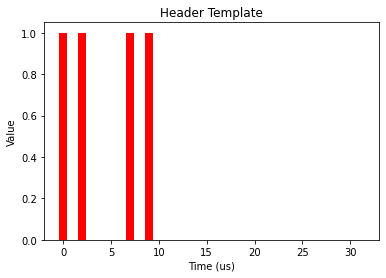

In [40]:
bar(range(32), template + 16 * [0], color="red")
title("Header Template")
xlabel("Time (us)")
ylabel("Value")

([<matplotlib.axis.XTick at 0x7f967c3eaaf0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

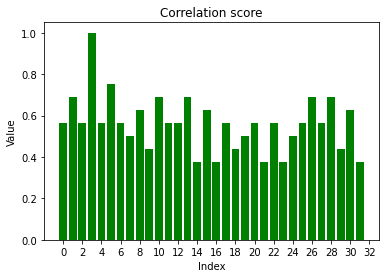

In [39]:
bar(range(32), correlation(template, buffer[:32 + 15]), color="green", )
title("Correlation score")
xlabel("Time (us)")
ylabel("Value")
xticks(np.arange(0, 33, 2))

In [27]:
len(correlation(template, buffer[:32]))

17

In [2]:
transmission_only = [(0,200), (500, 198), (1000, 191), (1500, 161), (2000, 83), (2500, 19), (3000, 16), (3500, 3), (4000, 0)]
transmission_and_error_correction = [(0, 100), (500, 99), (1000, 99), (1500, 98), (2000, 96), (2500, 91), (3000, 80), (3500, 56), (4000, 25)]
transmission_and_error_correction_and_compression = [(0, 193), (500, 187), (1000, 186), (1500, 183), (2000, 170), (2500, 131), (3000, 102), (3500, 64), (4000, 27)]

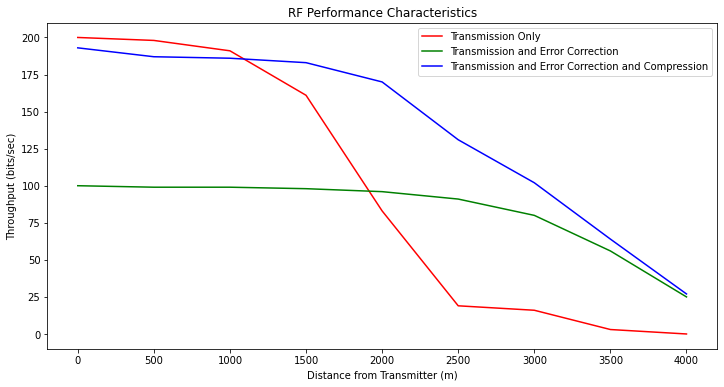

In [11]:
figure(figsize=(12, 6))
plot([x[0] for x in transmission_only], [x[1] for x in transmission_only], 'r-', label='Transmission Only')
plot([x[0] for x in transmission_and_error_correction], [x[1] for x in transmission_and_error_correction], 'g-', label='Transmission and Error Correction')
plot([x[0] for x in transmission_and_error_correction_and_compression], [x[1] for x in transmission_and_error_correction_and_compression], 'b-', label='Transmission and Error Correction and Compression')
xlabel('Distance from Transmitter (m)')
ylabel('Throughput (bits/sec)')
title("RF Performance Characteristics")
legend(loc='upper right')
show()

In [7]:
[transmission_only[0] for x in transmission_only]

[(0, 200),
 (0, 200),
 (0, 200),
 (0, 200),
 (0, 200),
 (0, 200),
 (0, 200),
 (0, 200),
 (0, 200)]

In [ ]:
def extract_bit(byte, pos):
    return (byte >> pos) & 0x01


def hamming_encode_nibble(data):
    # Get data bits
    d = [0, 0, 0, 0]
    d[0] = extract_bit(data, 0)
    d[1] = extract_bit(data, 1)
    d[2] = extract_bit(data, 2)
    d[3] = extract_bit(data, 3)

    # Calculate hamming bits
    h = [0, 0, 0]
    h[0] = (d[1] + d[2] + d[3]) % 2
    h[1] = (d[0] + d[2] + d[3]) % 2
    h[2] = (d[0] + d[1] + d[3]) % 2
    
    # Calculate parity bit, using even parity
    p = 0 ^ d[0] ^ d[1] ^ d[2] ^ d[3] ^ h[0] ^ h[1] ^ h[2]

    # Encode byte
    encoded = (data & 0x0f)
    encoded |= (p << 7) | (h[2] << 6) | (h[1] << 5) | (h[0] << 4)

    return encoded

In [3]:
# P H2 H1 H0 D3 D2 D1 D0
def hamming_decode_byte(byte):
   error, corrected = 0, 0
   s = [(extract_bit(byte, 1) + extract_bit(byte, 2) + extract_bit(byte, 3) + extract_bit(byte, 4)) % 2,
        (extract_bit(byte, 0) + extract_bit(byte, 2) + extract_bit(byte, 3) + extract_bit(byte, 5)) % 2,
        (extract_bit(byte, 0) + extract_bit(byte, 1) + extract_bit(byte, 3) + extract_bit(byte, 6)) % 2]
   syndrome = (s[0] << 2) | (s[1] << 1) | s[2]
   if syndrome:
       error += 1
       byte ^= (1 << SYNDROME_CHECK)
       corrected += 1
   p = 0
   for i in range(0, 7):
       p ^= extract_bit(byte, i)
   if p != extract_bit(byte, 7):
       if syndrome:
           corrected -= 1
       else:
           error += 1
           corrected += 1
   return ((byte & 0x0f), error, corrected)

In [4]:
hamming_decode_byte(0b11111111)

NameError: name 'extract_bit' is not defined